In [44]:
%pylab notebook
from __future__ import print_function
import datacube
import pandas as pd
import xarray as xr
from datetime import date, timedelta
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube_stats.statistics import GeoMedian
from sklearn.preprocessing import normalize


dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range

#Define temporal range
start_of_epoch = '2000-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = [
    'ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to present, full contintal coverage from 1987 onwards
        ] 


query = {
    'time': (start_of_epoch, end_of_epoch),
}

#your area of interest
lat_min = -17.968 #-17.55 down
lat_max = -17.925 #-17.50 up
lon_min = 146.127 #145.95 left
lon_max = 146.186 #146.00 right
   
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2016-12-31'), 'x': (146.127, 146.186), 'y': (-17.925, -17.968), 'crs': 'EPSG:4326'}


In [27]:
start_of_event= '2011-01-26'
end_of_event= '2011-02-06'

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime

# Extract data from Open Datacube

In [4]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [5]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_free_threshold = 0.80  ###User modification: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [6]:
sensor_nbar

<xarray.Dataset>
Dimensions:  (time: 127, x: 270, y: 218)
Coordinates:
  * time     (time) datetime64[ns] 2003-06-29T23:52:33 2003-07-15T23:52:49 ...
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
Data variables:
    green    (time, y, x) int16 420 478 478 478 478 420 420 420 420 420 420 ...
    red      (time, y, x) int16 45 93 93 93 93 93 93 93 93 93 141 93 93 93 ...
    nir      (time, y, x) int16 74 74 132 74 74 74 74 74 74 74 74 74 132 132 ...
    swir1    (time, y, x) int16 28 10 10 70 28 10 10 10 10 10 10 10 10 10 28 ...
Attributes:
    crs:      EPSG:3577

In [7]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 57, x: 270, y: 218)
 Coordinates:
   * time     (time) datetime64[ns] 2003-06-29T23:52:33 ...
   * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
   * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
 Data variables:
     green    (time, y, x) float64 420.0 478.0 478.0 478.0 478.0 420.0 420.0 ...
     red      (time, y, x) float64 45.0 93.0 93.0 93.0 93.0 93.0 93.0 93.0 ...
     nir      (time, y, x) float64 74.0 74.0 132.0 74.0 74.0 74.0 74.0 74.0 ...
     swir1    (time, y, x) float64 28.0 10.0 10.0 70.0 28.0 10.0 10.0 10.0 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 135, x: 270, y: 218)
 Coordinates:
   * time     (time) datetime64[ns] 2000-01-21T00:09:11.500000 ...
   * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
   * x        (x) float64 1.493e+

In [8]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

# Plot imagery and NDVI for geomedian of all data before cyclone

In [10]:
#remove product data variable from array to enable GeoMedian code
nbar_clean=nbar_clean.drop('product')

nbar_gm= nbar_clean.sel(time=slice(start_of_epoch, start_of_event))

#geomedian transform
nbar_gm=GeoMedian().compute(nbar_gm)
nbar_gm

<xarray.Dataset>
Dimensions:  (x: 270, y: 218)
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
Data variables:
    green    (y, x) float64 379.6 375.9 380.2 383.8 386.5 382.1 377.5 381.7 ...
    red      (y, x) float64 159.6 161.6 170.5 169.7 172.9 170.4 165.1 165.4 ...
    nir      (y, x) float64 159.6 160.3 158.8 165.0 163.9 159.9 160.1 159.2 ...
    swir1    (y, x) float64 81.19 83.84 82.93 89.09 87.55 83.19 83.08 84.71 ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1493450.00|\n| 0.00,-25.00,-1996550.00|\n| 0.00,...

In [11]:
#Prepare imagery
rgb = nbar_gm.to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


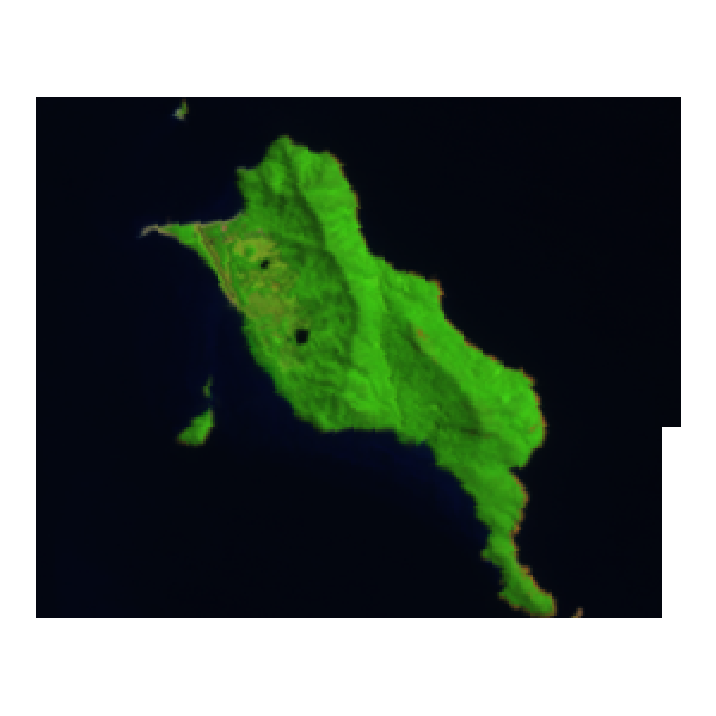

In [15]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required

#Edit plot title ##User should format as required
# plt.title('Gauge: '+gauge_of_interest +'   Date: '+str(time_slice_actual)[0:-9]  + 
#           '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
#           '   Percentage exceedance: '+ str(perexc_title2) + '%', size=10) 

#Add marker to show location of stream gauge 
# plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=150)
plt.imshow(scaled, interpolation = 'nearest')
#            extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
#                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

In [76]:
#Calculate NDVI
ndvi = ((nbar_gm.nir-nbar_gm.red)/(nbar_gm.nir+nbar_gm.red))
ndvi

<xarray.DataArray (y: 218, x: 270)>
array([[ -7.298961e-05,  -4.003502e-03,  -3.570193e-02, ...,  -7.104627e-03,
          6.022456e-04,  -1.557970e-02],
       [ -1.772720e-02,  -3.005908e-02,  -1.875966e-02, ...,  -1.605424e-02,
         -7.034274e-03,  -1.634984e-02],
       [ -2.411584e-02,  -2.323477e-02,  -2.628495e-02, ...,  -1.283498e-02,
         -1.380313e-02,  -9.144438e-03],
       ..., 
       [ -6.423384e-02,  -9.317786e-02,  -9.558890e-02, ...,            nan,
                   nan,            nan],
       [ -8.872114e-02,  -8.685081e-02,  -7.775446e-02, ...,            nan,
                   nan,            nan],
       [ -7.796943e-02,  -7.866963e-02,  -8.635628e-02, ...,            nan,
                   nan,            nan]])
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...

<IPython.core.display.Javascript object>


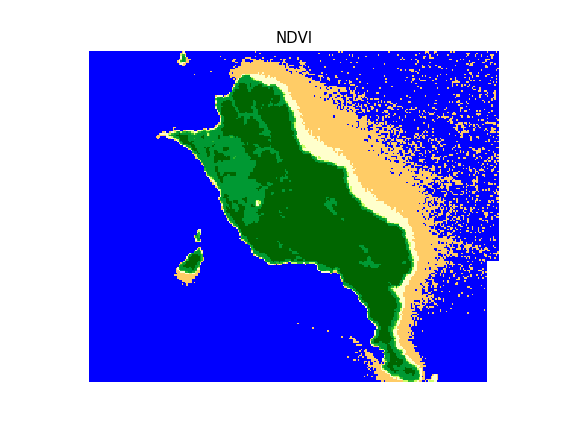

(-0.5, 269.5, 217.5, -0.5)

In [77]:
#This controls the colour maps used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

fig = plt.figure()
plt.title('NDVI')
plt.imshow(ndvi,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm)
plt.axis('off')#remove axis ##User should delete code if required

# Plot imagery and NDVI for timeslive after tropical cyclone

In [78]:
#Prepare imagery
rgb2 = nbar_clean.sel(time =end_of_event, method = 'backfill').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb2 = rgb2.astype('double')
clipped_visible2 = rgb2.where(rgb2<fake_saturation).fillna(fake_saturation)
max_val2 = clipped_visible2.max(['y', 'x'])
scaled2 = (clipped_visible2 / max_val2)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


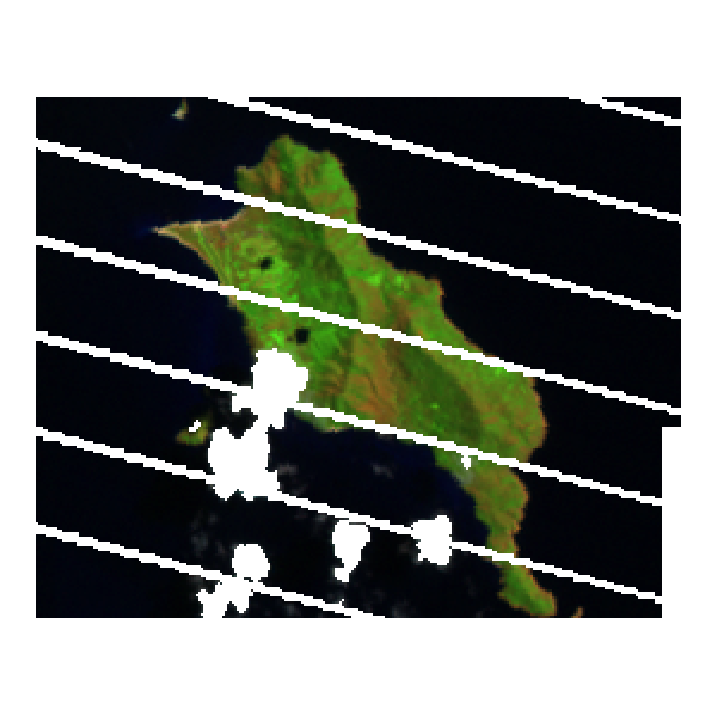

In [79]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required

#Edit plot title ##User should format as required
# plt.title('Gauge: '+gauge_of_interest +'   Date: '+str(time_slice_actual)[0:-9]  + 
#           '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
#           '   Percentage exceedance: '+ str(perexc_title2) + '%', size=10) 

#Add marker to show location of stream gauge 
# plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=150)
plt.imshow(scaled2, interpolation = 'nearest')
#            extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
#                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

In [75]:
ndvi_after_event = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi_after_event

ndvi_of_interest2= ndvi_after_event.sel(time = end_of_event, method='backfill')
ndvi_of_interest2

<xarray.DataArray (y: 218, x: 270)>
array([[ 0.      ,  0.218107,  0.045226, ...,  0.147541,  0.147541, -0.122302],
       [ 0.      ,  0.1341  , -0.041475, ...,  0.044776, -0.22293 ,  0.044776],
       [ 0.045226,  0.315556,  0.218107, ..., -0.122302, -0.302857, -0.122302],
       ..., 
       [-0.174603, -0.114894, -0.114894, ...,       nan,       nan,       nan],
       [-0.364583, -0.364583, -0.416268, ...,       nan,       nan,       nan],
       [-0.364583, -0.416268, -0.275261, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
    time     datetime64[ns] 2011-03-24T00:09:57.500000

<IPython.core.display.Javascript object>


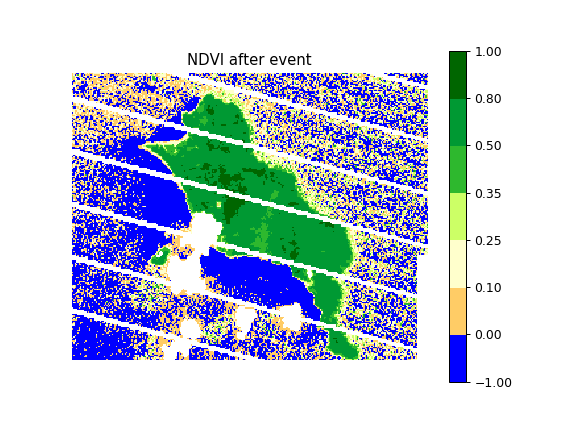

In [80]:
fig = plt.figure()
plt.title('NDVI after event')
plt.axis('off')#remove axis ##User should delete code if required
i=plt.imshow(ndvi_of_interest2,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm)
fig.colorbar(i)

# Plot change in NDVI

In [81]:
# ndvi=(((ndvi-np.amin(ndvi))/(np.amax(ndvi)-np.amin(ndvi)))*100)
# ndvi_of_interest2=(((ndvi_of_interest2-np.amin(ndvi_of_interest2))/(np.amax(ndvi_of_interest2)-np.amin(ndvi_of_interest2)))*100)

ndvi_change= ndvi-ndvi_of_interest2
ndvi_change=(((ndvi_change-np.amin(ndvi_change))/(np.amax(ndvi_change)-np.amin(ndvi_change)))*100)

<IPython.core.display.Javascript object>


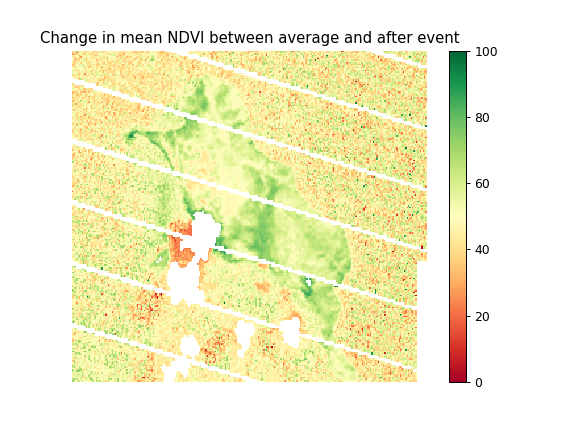

In [82]:
fig = plt.figure()
ndvi_change.plot(cmap = 'RdYlGn')
plt.title('Change in mean NDVI between average and after event')
plt.axis('off')#remove axis ##User should delete code if required
plt.show()